# Тестовое задание

## Импорт необходимых библиотек

In [14]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import random
import warnings
import os

from tqdm import tqdm
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")

: 

## Зафиксируем сид для воспроизводимости

In [2]:
DEFAULT_RANDOM_SEED = 42

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [3]:
seedEverything(1)

## Определяем на чем будет происходить обучение

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Определяем структуру простой сверточной нейронной сети описанной в статье

In [5]:
class BaselineMNISTNetwork(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=16, kernel_size=(5, 5), stride=1
        )

        self.ReLU = nn.ReLU()

        self.flatten = nn.Flatten()

        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=(5, 5), stride=1
        )

        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=512, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.pool1(self.ReLU(self.conv1(x)))
        x = self.pool2(self.ReLU(self.conv2(x)))
        x = self.flatten(x)
        x = self.ReLU(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

## Фиксируем необходимые гиперпараметры

In [6]:
batch_size = 32
learning_rate = 0.01
epochs = 10
num_classes = 10

## Загружаем набор данных для обучения MNIST

In [24]:
traindataset = torchvision.datasets.MNIST('/datasets/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)

testdataset = torchvision.datasets.MNIST('/datasets/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
testloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, shuffle=True)

## Определяем модель, функцию потерь и оптимизатор

In [8]:
criterion = nn.CrossEntropyLoss()
model = BaselineMNISTNetwork(num_classes)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

## Метрика качества

In [9]:
metric_func = accuracy_score

## Процесс обучения модели

In [22]:
def train(model, trainloader, testloader, epochs, optimizer, criterion, metric_func):

  model.train()

  bar = tqdm(total=epochs, ncols=120)
  for epoch in range(epochs):

    train_acc = 0
    test_acc = 0
    train_loss = 0

    for (batch_idx, train_batch) in enumerate(trainloader):
      images, label = train_batch[0].to(device), train_batch[1].to(device)
      logits = model(images)
      preds = logits.argmax(dim=1)
      loss = criterion(logits, label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_acc += metric_func(preds.cpu().numpy(), label.cpu().numpy())

    train_acc = train_acc / len(trainloader)
    train_loss = train_loss / len(trainloader)

    model.eval()

    with torch.no_grad():
      for test_batch in testloader:
        images, label = test_batch[0].to(device), test_batch[1].to(device)
        logits = model(images)
        preds = logits.argmax(dim=1)
        test_acc += metric_func(preds.cpu().numpy(), label.cpu().numpy())

    test_acc = test_acc / len(testloader)

    model.train()

    bar.set_description(f"|EPOCH: {epoch+1}|TRAIN_LOSS: {round(train_loss, 3)}|TRAIN_ACC: {round(train_acc, 3)}|TEST_ACC: {round(test_acc, 3)}")
    bar.update()

  return model

## Запускаем процесс обучения модели

In [23]:
model = train(model, trainloader, testloader, epochs, optimizer, criterion, metric_func)


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]
|EPOCH: 1|TRAIN_LOSS: 1.468|TRAIN_ACC: 0.994|TEST_ACC: 0.99:   0%|                               | 0/10 [00:25<?, ?it/s]
|EPOCH: 1|TRAIN_LOSS: 1.468|TRAIN_ACC: 0.994|TEST_ACC: 0.99:  10%|██▎                    | 1/10 [00:25<03:49, 25.55s/it]
|EPOCH: 2|TRAIN_LOSS: 1.467|TRAIN_ACC: 0.994|TEST_ACC: 0.99:  10%|██▎                    | 1/10 [00:51<03:49, 25.55s/it]
|EPOCH: 2|TRAIN_LOSS: 1.467|TRAIN_ACC: 0.994|TEST_ACC: 0.99:  20%|████▌                  | 2/10 [00:51<03:24, 25.52s/it]
|EPOCH: 3|TRAIN_LOSS: 1.467|TRAIN_ACC: 0.995|TEST_ACC: 0.989:  20%|████▍                 | 2/10 [01:16<03:24, 25.52s/it]
|EPOCH: 3|TRAIN_LOSS: 1.467|TRAIN_ACC: 0.995|TEST_ACC: 0.989:  30%|██████▌               | 3/10 [01:16<02:57, 25.37s/it]
|EPOCH: 4|TRAIN_LOSS: 1.466|TRAIN_ACC: 0.995|TEST_ACC: 0.99:  30%|██████▉                | 3/10 [01:41<02:57, 25.37s/it]
|EPOCH: 4|TRAIN_LOSS: 1.466|TRA

## Задание

* Попробуйте реализовать backdoor-атаку, описанную в статье в главе **4. Case Study: MNIST Digit Recognition Attack**.
* В качестве триггера, внедряемого в изображение, предлагается использовать представленный в статье вариант.
* Возможно, вам захочется придумать свой собственный триггер (пример изображен на рисунке ниже).
* Подумайте, каким образом можно сделать используемый триггер более незаметным.
* Для выбора целевой метки можно воспользоваться механизмом, представленным в статье, или выбрать свою собственную из 10 представленных классов (помните, что целевая метка не должна совпадать с истинной меткой для заражённых изображений в наборе данных).
* В качестве модели сверточной нейронной сети используйте модель, реализованную ниже.
* Набор данных на данном этапе уже загружен (**traindataset**, **testdataset**). Посмотрите, что находится внутри данных наборов данных, и как можно получить изображения с метками классов. Далее внедрите выбранный вами триггер в отобранные из **traindataset** изображения, измените метки классов данных изображений на целевую и верните изменённые изображения в **traindataset**.
* Запустите обучение модели на заражённом **traindataset**.
* После обучения проверьте работоспособность атаки.

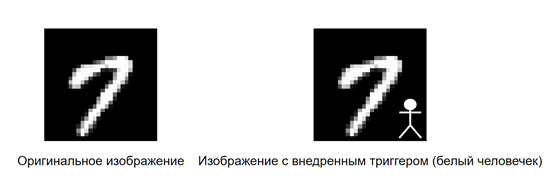

In [ ]:
# тут Ваш код